# Imports and Setup

In [75]:
import argparse
import glob
import os
import random
import re
import pandas as pd
import numpy as np
import csv
import json
from IPython.core.display import HTML
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Spacy setup. Need to be done once.
!pip -q install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
## !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [2]:
import spacy
from spacy.lang.es.examples import sentences 
from spacy import displacy

print(spacy.__version__)
print(pd.__version__)

from nltk.parse import stanford, corenlp
NLP_ES = spacy.load("es_core_news_sm")
NLP_EN = spacy.load("en_core_web_sm")

3.7.2
1.4.2


In [76]:
from config import Config
args = Config()

In [4]:
# Helper methods
def get_neighbors(idx, id_to_head, head_to_ids, verbosity):
    as_list = []
    as_map = dict()

    if idx in id_to_head:
        upstream = id_to_head[idx]
        downstream = []
        if idx in head_to_ids:
            downstream = head_to_ids[idx]

        # Add to neighbors list
        as_list = [upstream, *downstream]
        # Add to the neighbors map
        as_map[f'{idx}'] = upstream
        for i in downstream:
            as_map[f'{i}'] = idx

    if verbosity > 1:
        print(f'idx:{idx}, as_list: {as_list}, as_map: {as_map}')

    return (as_list, as_map)

def dep_parsing_tree(nlp, text, correction_index, verbosity=0):
    doc = nlp(text)
    js_str = doc.to_json()
    id_to_head = dict() #dict([(token["id"], token["head"]) for token in js_str["tokens"]])
    head_to_ids = dict()
    for token in js_str["tokens"]:
        id = token["id"]
        head = token["head"]
        if token['pos'] != 'PUNCT':
            id_to_head[id] = head
            if head in head_to_ids:
                head_to_ids[head].append(id)
            else:
                head_to_ids[head] = [id]
    if verbosity > 0:
        print(f'id -> head: {id_to_head}')
        print(f'head -> ids: {head_to_ids}')            
        
    pred_parse_order = dict()
    for cor_idx in correction_index:
        # Get the head for the current correction index
        (as_list, as_map) = get_neighbors(cor_idx, id_to_head, head_to_ids, verbosity)
        for i in as_list:
            (_, sub_map) = get_neighbors(i, id_to_head, head_to_ids, verbosity)
            as_map.update(sub_map)          
        pred_parse_order.update(as_map)

#         if cor_idx in id_to_head:
#             first_order = id_to_head[cor_idx] # Do we need the downstream dependencies as well here?
#             tt = head_to_ids[cor_idx]
#             for t in tt:
#                 # get second order
#             second_order = head_to_ids[first_order]
#             pred_parse_order[f'{cor_idx}'] = first_order
#             for i in second_order:
#                 pred_parse_order[f'{i}'] = first_order

    if verbosity > 0:
        df_dep_tree = pd.DataFrame()
        df_dep_tree['text'] = [token.text for token in doc]
        df_dep_tree['lemma'] = [token.lemma_ for token in doc]
        df_dep_tree['is_punctuation'] = [token.is_punct for token in doc]
        df_dep_tree['is_space'] = [token.is_space for token in doc]
        df_dep_tree['shape'] = [token.shape_ for token in doc]
        df_dep_tree['part_of_speech'] = [token.pos_ for token in doc]
        df_dep_tree['pos_tag'] = [token.tag_ for token in doc]
        df_dep_tree['head'] = [token.head.text for token in doc] 
        df_dep_tree['dep'] = [token.dep_ for token in doc]
        html = displacy.render(doc, style="dep")
        HTML(html)
    return pred_parse_order

In [77]:
# Define class id mappers
classes_ids = {
    'az': 'az',
    'ga': 'ga',
    'ga-na': 'ga-na',
    'na': 'na'
}

# Load Data and do Sanity Tests

## Sanity on Full Data

In [26]:
def load():
    # Converters not working
    df = pd.read_csv(args.PROCESSED_DATA_FOLDER + "/final.csv", index_col=None, header=0)
    # The srouce, target and correction_index cols are loaded as string version of lists. Convert them to actual lists.
    df.source = df.apply(lambda row: eval(row.source), axis=1)
    df.target = df.apply(lambda row: eval(row.target), axis=1)
    df.correction_index = df.apply(lambda row: eval(row.correction_index), axis=1)
    
    df['evidence_index'] = np.empty((len(df), 0)).tolist()
    df['predicted_parsing_order'] = ""
    df['origin'] = 'A'
    return df

df = load()

In [27]:
# Check the columns
df.columns

Index(['Unnamed: 0', 'paragraph_id', 'sentence_id', 'course', 'essay_new',
       'annotated_sentence', 'anno_error_cnt', 'full_error_tag', 'order_tag',
       'error_tag', 'correction', 'error', 'target', 'correction_index',
       'error_type', 'source', 'new_error_type', 'evidence_index',
       'predicted_parsing_order', 'origin'],
      dtype='object')

In [28]:
# All rows should have an error_type
df[df.error_type.isnull()]

,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,error_tag,correction,error,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin


In [29]:
# Check for null values
df[df.notnull()].count()

Unnamed: 0                 5223
paragraph_id               5223
sentence_id                5223
course                     5223
essay_new                  5223
annotated_sentence         5223
anno_error_cnt             5223
full_error_tag             5223
order_tag                  5223
error_tag                  5223
correction                 5174
error                      4809
target                     5223
correction_index           5223
error_type                 5223
source                     5223
new_error_type             5223
evidence_index             5223
predicted_parsing_order    5223
origin                     5223
dtype: int64

In [30]:
df.isna().sum()

Unnamed: 0                   0
paragraph_id                 0
sentence_id                  0
course                       0
essay_new                    0
annotated_sentence           0
anno_error_cnt               0
full_error_tag               0
order_tag                    0
error_tag                    0
correction                  49
error                      414
target                       0
correction_index             0
error_type                   0
source                       0
new_error_type               0
evidence_index               0
predicted_parsing_order      0
origin                       0
dtype: int64

In [31]:
df.sample(n=5)

,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,error_tag,correction,error,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin
4970,951,1622,54d9400057dcab6f06a3394fb2e6573a6a23acdc54a062...,SPA 3,\n\nEn el ultimo día mis novia y yo tendríamos...,En el ultimo día [mis]{mi}<na:sp:det:an> novia...,2,[mis]{mi}<na:sp:det:an>,0,na:sp:det:an,mi,mis,"[En, el, ultimo, día, mi, novia, y, yo, tendrí...","[4, 18]",na:sp,"[En, el, ultimo, día, mis, novia, y, yo, tendr...",number agreement,[],,A
21,79,127,90325e78cab8c2708a30079d4b050dd1eba688026f1c44...,SPA 2,yo pienso Keanu es modesto y yo quiero conocer...,yo pienso Keanu es modesto y yo quiero conocer...,1,[]{a}<az:do:an>,0,az:do:an,a,NaN,"[yo, pienso, Keanu, es, modesto, y, yo, quiero...","[9, 22]",az:do,"[yo, pienso, Keanu, es, modesto, y, yo, quiero...",article,[],,A
32,86,139,7fcc1b964f356d5b3dad9225764cb914dda11c2bea8138...,SPA 2,Yo admiro Ian Somerhalder porque yo estoy inte...,Yo admiro []{a}<az:do:an> Ian Somerhalder porq...,1,[]{a}<az:do:an>,0,az:do:an,a,NaN,"[Yo, admiro, a, Ian, Somerhalder, porque, yo, ...","[2, 18]",az:do,"[Yo, admiro, [NONE], Ian, Somerhalder, porque,...",article,[],,A
3675,344,521,48364d632a1e651bf0bf2820da5de369bd83c4b09148f3...,SPA 3,Su idea de Communismo es un idea politica de u...,Su idea de Communismo es [un]{una}<ga:fm:det:i...,2,[un]{una}<ga:fm:det:inan>,0,ga:fm:det:inan,una,un,"[Su, idea, de, Communismo, es, una, idea, poli...","[5, 22]",ga:fm,"[Su, idea, de, Communismo, es, un, idea, polit...",gender agreement,[],,A
4984,955,1630,81f042c5718ae0e510b7efe2d84dbd69c56b9efbbcfab0...,SPA 3,Vamos a tener todos nuestra vacunas en caso de...,Vamos a tener [todos]{todas}<na:ps:det:inan> [...,3,[nuestra]{nuestras}<na:ps:pron:inan>,1,na:ps:pron:inan,nuestras,nuestra,"[Vamos, a, tener, todas, nuestras, vacunas, en...","[4, 20]",na:ps,"[Vamos, a, tener, todas, nuestra, vacunas, en,...",number agreement,[],,A


## Split Dataset into With Errors and Without Errors

In [32]:
# Split dataset into two dataframes one with errors and one without
df_no_errors = df.query('error_type == "None"').copy()
df_no_errors.reset_index(inplace=True)
df_no_errors.rename(columns={'index': "orig_index"}, inplace=True)
df_errors = df.query('error_type != "None"').copy()
df_errors['orig_error_type'] = df_errors['error_type']

df_errors.reset_index(inplace=True)
df_errors.rename(columns={'index': "orig_index"}, inplace=True)
df_errors


,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,error,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type
0,0,6,13,452c9dc1a268e1cd5d57357198dc84aa00deacae5ec6c2...,SPA 1,No confundas Selena Gomez con Selena Quintanil...,No confundas []{a}<az:do:an> Selena Gomez con ...,1,[]{a}<az:do:an>,0,...,NaN,"[No, confundas, a, Selena, Gomez, con, Selena,...","[2, 19]",az:do,"[No, confundas, [NONE], Selena, Gomez, con, Se...",article,[],,A,az:do
1,1,9,18,e627490f6722ef9caeb07e150107b31bcc9c088016a579...,SPA 2,"Un Otro famoso actor, que llama Nicolas Cage, ...","Un Otro famoso actor, que llama Nicolas Cage, ...",1,[]{a}<az:do:an>,0,...,NaN,"[Un, Otro, famoso, actor, ,, que, llama, Nicol...","[11, 32]",az:do,"[Un, Otro, famoso, actor, ,, que, llama, Nicol...",article,[],,A,az:do
2,2,17,28,0e02104bc91f910260846ddba52137596f5b83525260c1...,SPA 3,Princesa Anna y sus amigas quieren que ayuden ...,Princesa Anna y sus amigas quieren que ayuden ...,1,[]{a}<az:do:an>,0,...,NaN,"[Princesa, Anna, y, sus, amigas, quieren, que,...","[8, 21]",az:do,"[Princesa, Anna, y, sus, amigas, quieren, que,...",article,[],,A,az:do
3,3,17,28,dda3163fe647d016c4f212fd794343bd1b2446243a6ac3...,SPA 3,Pero Eleanor dice su secreto a su amigo Chiddi...,Pero Eleanor dice su secreto a su amigo Chiddi...,1,[]{a}<az:do:an>,0,...,NaN,"[Pero, Eleanor, dice, su, secreto, a, su, amig...","[13, 30]",az:do,"[Pero, Eleanor, dice, su, secreto, a, su, amig...",article,[],,A,az:do
4,4,17,28,abb0ff0f493ec9cabdf7eaeb7b0e0078879fbe59f5768f...,SPA 3,Chiddi enseña Eleanor sobre cómo ser una perso...,Chiddi enseña []{a}<az:do:an> Eleanor sobre có...,1,[]{a}<az:do:an>,0,...,NaN,"[Chiddi, enseña, a, Eleanor, sobre, cómo, ser,...","[2, 14]",az:do,"[Chiddi, enseña, [NONE], Eleanor, sobre, cómo,...",article,[],,A,az:do
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,5218,44,1492,f6f91450d7fd28e3df5266da689a9ee900195ee3d9a435...,SPA 3,Llevaria mi familia al Museo Nacional para mir...,Llevaria mi familia al Museo Nacional para mir...,4,[los]{las}<ga:fm:det:inan>,1,...,los,"[Llevaria, mi, familia, al, Museo, Nacional, p...","[9, 70]",ga:fm,"[Llevaria, mi, familia, al, Museo, Nacional, p...",gender agreement,[],,A,ga:fm
5219,5219,44,1492,f6f91450d7fd28e3df5266da689a9ee900195ee3d9a435...,SPA 3,Llevaria mi familia al Museo Nacional para mir...,Llevaria mi familia al Museo Nacional para mir...,4,[todo]{todas}<ga:na:fm:ps:det:inan>,2,...,todo,"[Llevaria, mi, familia, al, Museo, Nacional, p...","[34, 95]",ga:na:fm:ps,"[Llevaria, mi, familia, al, Museo, Nacional, p...",gender and number agreement,[],,A,ga:na:fm:ps
5220,5220,44,1492,f6f91450d7fd28e3df5266da689a9ee900195ee3d9a435...,SPA 3,Llevaria mi familia al Museo Nacional para mir...,Llevaria mi familia al Museo Nacional para mir...,4,[los]{las}<ga:fm:det:inan>,3,...,los,"[Llevaria, mi, familia, al, Museo, Nacional, p...","[35, 96]",ga:fm,"[Llevaria, mi, familia, al, Museo, Nacional, p...",gender agreement,[],,A,ga:fm
5221,5221,47,1623,d136aa5a6cdd9ba0c56a12b3e4b24b37f0f8293d013291...,SPA 2,"Entonces será certificado como “perfecto"".",Entonces será [certificado]{certificadas}<ga:f...,2,[certificado]{certificadas}<ga:fm:adj:inan>,0,...,certificado,"[Entonces, será, certificadas, como, "", perfec...","[2, 11]",ga:fm,"[Entonces, será, certificado, como, "", perfect...",gender agreement,[],,A,ga:fm


In [33]:
df_errors.to_csv(args.PROCESSED_DATA_FOLDER + "/final_with_errors.csv", index=False)

In [35]:
df_errors.index[(df_errors.essay_new == 'Entonces será certificado como “perfecto".')]

Int64Index([5221, 5222], dtype='int64')

In [36]:
df_errors[df_errors.notnull()].count()

orig_index                 5223
Unnamed: 0                 5223
paragraph_id               5223
sentence_id                5223
course                     5223
essay_new                  5223
annotated_sentence         5223
anno_error_cnt             5223
full_error_tag             5223
order_tag                  5223
error_tag                  5223
correction                 5174
error                      4809
target                     5223
correction_index           5223
error_type                 5223
source                     5223
new_error_type             5223
evidence_index             5223
predicted_parsing_order    5223
origin                     5223
orig_error_type            5223
dtype: int64

In [37]:
df_no_errors[df_no_errors.notnull()].count()

orig_index                 0
Unnamed: 0                 0
paragraph_id               0
sentence_id                0
course                     0
essay_new                  0
annotated_sentence         0
anno_error_cnt             0
full_error_tag             0
order_tag                  0
error_tag                  0
correction                 0
error                      0
target                     0
correction_index           0
error_type                 0
source                     0
new_error_type             0
evidence_index             0
predicted_parsing_order    0
origin                     0
dtype: int64

In [38]:
df_errors.full_error_tag.unique()

array(['[]{a}<az:do:an>', '[a]{}<za:do:inan>', '[al]{al}<aa:do:an>', ...,
       '[fresco]{frescos}<na:ps:adj:inan>',
       '[encurtido]{encurtidos}<na:ps:adj:inan>',
       '[certificado]{certificadas}<ga:fm:adj:inan>'], dtype=object)

In [40]:
df_errors.error_type.unique()

array(['az:do', 'za:do', 'aa:do', 'aa:io', 'az:io', 'na:ps', 'ga:fm',
       'ga:mf:det:aty', 'ga:mf', 'ig:f', 'na:sp', 'in:s', 'ga:na:fm:ps',
       'ga:fm:det:aty', 'ga:ps', 'ig:e', 'ig:m', 'ga:na:mf:ps',
       'ga:mf:noun:aty', 'ga:mf:adj:aty', 'ga:na:fm:sp', 'ga:na:mf:sp',
       'in:p', 'ga:fm:adj:aty', 'ga:fm:noun:aty', 'ig:in:f:s',
       'ga:fm:gat:noun', 'in:p:gat:noun', 'na:sp:gat:noun',
       'ga:mf:pron:aty', 'in:s:gat:noun'], dtype=object)

In [41]:
# Reduce the number of error classes to 4 - ga, na, ga-na and az.
error_map = {
'aa:do': 'az',
'az:do': 'az',
'za:do': 'az',
'aa:io': 'az',
'az:io': 'az',
'na:ps': 'na',
'ga:fm': 'ga',
'ga:mf:det:aty': 'ga',
'ga:mf': 'ga',
'ig:f': 'na',
'na:sp': 'na',
'in:s': 'na',
'ga:na:fm:ps': 'ga-na',
'ga:fm:det:aty': 'ga',
'ga:ps': 'ga',
'ig:e': 'na',
'ig:m': 'na',
'ga:na:mf:ps': 'ga-na',
'ga:mf:noun:aty': 'ga',
'ga:mf:adj:aty': 'ga',
'ga:na:fm:sp': 'ga-na',
'ga:na:mf:sp': 'ga-na',
'in:p': 'na',
'ga:fm:adj:aty': 'ga',
'ga:fm:noun:aty': 'ga',
'ig:in:f:s': 'na',
'ga:fm:gat:noun': 'ga',
'in:p:gat:noun': 'na',
'na:sp:gat:noun': 'na',
'ga:mf:pron:aty': 'ga',
'in:s:gat:noun': 'na',
'ga': 'ga'}

df_errors['error_type'] = df_errors.apply(lambda row: error_map[row.orig_error_type], axis=1)

In [42]:
df_errors.error_type.value_counts()

ga       2836
na       1619
az        477
ga-na     291
Name: error_type, dtype: int64

## Sanity Check Lines with Errors

In [44]:
def compute_status(row):
    num_len_mismatch = 0
    num_extra_corrections = 0
    source = row.source
    target = row.target
    correction_index = set(row.correction_index)
    row_status = 'GOOD'
    if len(source) != len(target):
        num_len_mismatch = num_len_mismatch + 1
        row_status = 'LEN_MISMATCH'
    else:
        mismatches = map(lambda x: x[0] == x[1], zip(source, target))
        for (i, flag) in enumerate(mismatches):
            if not flag and i not in correction_index:
                # print('Extra corrections')
                num_extra_corrections = num_extra_corrections + 1
                row_status = 'EXTRA_CORRECTIONS'
                break
    # row['status'] = row_status
    return row_status
    # print(f'Found {num_len_mismatch} entries and {num_extra_corrections} entries with extra corrections')

def check_errors():
    df_tt = df_errors[['orig_index', 'sentence_id', 'essay_new', 'source', 'target', 'correction_index']].copy(deep=True)
    df_tt['status'] = df_tt.apply(compute_status, axis=1)
    df_tt['has_annotation'] = df_tt.apply(lambda row: '<' in row.source or '<' in row.target, axis=1)
    return df_tt
    
df_error_status = check_errors()

In [47]:
print('Should have just GOOD rows')
print(df_error_status.status.value_counts())

print()
print('Should not have annotations')
print(df_error_status.has_annotation.value_counts())

with pd.option_context('display.max_colwidth', None):
    display(df_error_status[df_error_status['status'] == 'EXTRA_CORRECTIONS'])
    print("----------------------")
    display(df_error_status[df_error_status.has_annotation == True])

Should have just GOOD rows
GOOD    5223
Name: status, dtype: int64

Should not have annotations
False    5223
Name: has_annotation, dtype: int64


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation


----------------------


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation


# Explore EXPECT dataset

In [25]:
def load_expect_data(num_lines=None):
    expect_train_file = f"{args.EXPLAINABLE_GEC_DATA_FOLDER}/train.json"
    with open(expect_train_file, "r") as file1:
        count = 0
        rows = file1.readlines()
        df = pd.DataFrame([eval(row) for row in rows])
        df['source_org'] = df.source.map(lambda v: ' '.join(v).replace(" .", "."))        
        df['target_org'] = df.target.map(lambda v: ' '.join(v).replace(" .", "."))
        return df

df_expect = load_expect_data()


In [26]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.sample(5))

,target,source,evidence_index,correction_index,error_type,predicted_parsing_order,origin,source_org,target_org
8524,"[First, of, all, ,, transport, is, the, most, significant, carbon, dioxide, [NONE], emitter, .]","[First, of, all, ,, transport, is, the, most, significant, carbon, dioxide, 's, emitter, .]","[9, 10, 12, 24, 25, 27]","[11, 26]",POS Confusion,"{'11': 1, '26': 1}",B,"First of all , transport is the most significant carbon dioxide 's emitter.","First of all , transport is the most significant carbon dioxide [NONE] emitter."
5919,"[To, put, it, simply, ,, the, new, generation, has, decided, to, take, their, driving, licence, and, I, have, seen, this, around, me, ,, with, my, colleagues, ,, my, friends, ,, my, family, .]","[To, put, it, simply, ,, the, new, generation, has, decided, to, take, their, driving, licence, and, I, have, seen, this, around, me, ,, [NONE], my, colleagues, ,, my, friends, ,, my, family, .]","[24, 25, 58, 59]","[23, 57]",Preposition,"{'18': 3, '22': 2, '23': 1, '25': 3, '26': 2, '28': 3, '29': 3, '52': 3, '56': 2, '57': 1, '59': 3, '60': 2, '62': 3, '63': 3}",A,"To put it simply , the new generation has decided to take their driving licence and I have seen this around me , [NONE] my colleagues , my friends , my family.","To put it simply , the new generation has decided to take their driving licence and I have seen this around me , with my colleagues , my friends , my family."
5849,"[Basketball, is, recognized, by, people, all, over, the, world, .]","[Basketball, is, recognize, by, people, all, over, the, world, .]","[0, 1, 3, 4, 11, 12, 14, 15]","[2, 13]",Participle,"{'0': 2, '1': 2, '2': 1, '3': 2, '4': 3, '9': 2, '11': 2, '12': 2, '13': 1, '14': 2, '15': 3, '20': 2}",A,Basketball is recognize by people all over the world.,Basketball is recognized by people all over the world.
9125,"[Anyway, ,, I, still, love, him, and, still, have, the, hope, that, this, is, just, a, temporary, period, in, our, life, and, he, will, be, back, to, the, man, I, loved, once, ,, especially, since, we, have, the, most, amazing, reason, to, live, for, ;, it, 's, our, beautiful, son, ,, our, angel, and, the, amazing, love, of, our, lives, .]","[Anyway, ,, I, still, love, him, and, still, have, the, hope, that, this, is, just, a, temporary, period, in, our, life, and, he, will, be, back, to, the, man, I, loved, once, ,, especially, that, we, have, the, most, amazing, reason, to, live, for, ;, it, 's, our, beautiful, son, ,, our, angel, and, the, amazing, love, of, our, lives, .]",[],"[34, 96]",Others,"{'24': 3, '33': 2, '34': 1, '86': 3, '95': 2, '96': 1}",B,"Anyway , I still love him and still have the hope that this is just a temporary period in our life and he will be back to the man I loved once , especially that we have the most amazing reason to live for ; it 's our beautiful son , our angel and the amazing love of our lives.","Anyway , I still love him and still have the hope that this is just a temporary period in our life and he will be back to the man I loved once , especially since we have the most amazing reason to live for ; it 's our beautiful son , our angel and the amazing love of our lives."
7122,"[If, you, want, to, play, this, sport, ,, you, have, to, make, a, really, big, effort, and, try, to, practise, as, much, as, possible, .]","[If, you, want, to, play, this, sport, ,, I, have, to, make, a, really, big, effort, and, try, to, practise, as, much, as, possible, .]",[],"[8, 34]",Possessive,"{'2': 2, '8': 1, '9': 3, '28': 2, '34': 1, '35': 3}",B,"If you want to play this sport , I have to make a really big effort and try to practise as much as possible.","If you want to play this sport , you have to make a really big effort and try to practise as much as possible."


In [27]:
df_expect.isna().sum()

target                     0
source                     0
evidence_index             0
correction_index           0
error_type                 0
predicted_parsing_order    0
origin                     0
source_org                 0
target_org                 0
dtype: int64

## Dependency parsing tree on EXPECT

In [28]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.iloc[11872])

target                                 [The, periodic, movement, of, the, minute, hand, compared, to, the, smooth, path, of, the, second, hand, .]
source                                     [The, periodic, move, of, the, minute, hand, compared, to, the, smooth, path, of, the, second, hand, .]
evidence_index                                                                                                                      [0, 1, 18, 19]
correction_index                                                                                                                           [2, 20]
error_type                                                                                                                           POS Confusion
predicted_parsing_order    {'0': 2, '1': 2, '2': 1, '3': 2, '5': 3, '6': 3, '7': 2, '18': 2, '19': 2, '20': 1, '21': 2, '23': 3, '24': 3, '25': 2}
origin                                                                                                                

In [29]:
def show_one_EXPECT(nlp, row_idx):
    row = df_expect.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.target_org, row.correction_index, verbosity=1)
    print()
    print(f'Orig: {row.source_org}')
    print(f'Corr: {row.target_org}')
    concacted = [*row.source, 'SEP', *row.target]
    print(f'Concatenated: {concacted}')
    print(f'Corr: {row.target_org}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(row.target) + 1}')
    print(f'Original pred_parse_order: {row.predicted_parsing_order}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

# show_one_EXPECT(11872)
show_one_EXPECT(NLP_EN, 1314)
    

id -> head: {0: 1, 1: 3, 2: 3, 3: 3, 4: 5, 5: 3}
head -> ids: {1: [0], 3: [1, 2, 3, 5], 5: [4]}



Orig: Castle also has a courtyard.
Corr: The castle also has a courtyard.
Concatenated: ['Castle', 'also', 'has', 'a', 'courtyard', '.', 'SEP', 'The', 'castle', 'also', 'has', 'a', 'courtyard', '.']
Corr: The castle also has a courtyard.

Correction index: [0, 1, 8]

Corrected offset: 8
Original pred_parse_order: {'0': 1, '1': 1, '3': 2, '8': 1, '10': 2}

computed pred_parse_order: {'0': 1, '1': 3, '3': 3, '2': 3, '5': 3}


In [30]:
print("Evidence words are important for GEC")
print(f'computed pred_parse_order: {dep_parsing_tree(spacy.load("en_core_web_sm"), "Evidence words are important for GEC", [2])}')


Evidence words are important for GEC
computed pred_parse_order: {'2': 2, '1': 2, '3': 2, '4': 2, '0': 1, '5': 4}


In [31]:
show_one_EXPECT(NLP_EN, 1314)

id -> head: {0: 1, 1: 3, 2: 3, 3: 3, 4: 5, 5: 3}
head -> ids: {1: [0], 3: [1, 2, 3, 5], 5: [4]}



Orig: Castle also has a courtyard.
Corr: The castle also has a courtyard.
Concatenated: ['Castle', 'also', 'has', 'a', 'courtyard', '.', 'SEP', 'The', 'castle', 'also', 'has', 'a', 'courtyard', '.']
Corr: The castle also has a courtyard.

Correction index: [0, 1, 8]

Corrected offset: 8
Original pred_parse_order: {'0': 1, '1': 1, '3': 2, '8': 1, '10': 2}

computed pred_parse_order: {'0': 1, '1': 3, '3': 3, '2': 3, '5': 3}


In [32]:
show_one_EXPECT(NLP_EN, 11872)

id -> head: {0: 2, 1: 2, 2: 7, 3: 2, 4: 6, 5: 6, 6: 3, 7: 7, 8: 7, 9: 11, 10: 11, 11: 8, 12: 11, 13: 15, 14: 15, 15: 12}
head -> ids: {2: [0, 1, 3], 7: [2, 7, 8], 6: [4, 5], 3: [6], 11: [9, 10, 12], 8: [11], 15: [13, 14], 12: [15]}



Orig: The periodic move of the minute hand compared to the smooth path of the second hand.
Corr: The periodic movement of the minute hand compared to the smooth path of the second hand.
Concatenated: ['The', 'periodic', 'move', 'of', 'the', 'minute', 'hand', 'compared', 'to', 'the', 'smooth', 'path', 'of', 'the', 'second', 'hand', '.', 'SEP', 'The', 'periodic', 'movement', 'of', 'the', 'minute', 'hand', 'compared', 'to', 'the', 'smooth', 'path', 'of', 'the', 'second', 'hand', '.']
Corr: The periodic movement of the minute hand compared to the smooth path of the second hand.

Correction index: [2, 20]

Corrected offset: 18
Original pred_parse_order: {'0': 2, '1': 2, '2': 1, '3': 2, '5': 3, '6': 3, '7': 2, '18': 2, '19': 2, '20': 1, '21': 2, '23': 3, '24': 3, '25': 2}

computed pred_parse_order: {'2': 7, '0': 2, '1': 2, '3': 2, '7': 7, '8': 7, '6': 3}


In [33]:
show_one_EXPECT(NLP_EN, 1289)

id -> head: {0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 6, 6: 4}
head -> ids: {1: [0], 2: [1, 2, 3, 4], 6: [5], 4: [6]}



Orig: The waiter come and took the order.
Corr: The waiter came and took the order.
Concatenated: ['The', 'waiter', 'come', 'and', 'took', 'the', 'order', '.', 'SEP', 'The', 'waiter', 'came', 'and', 'took', 'the', 'order', '.']
Corr: The waiter came and took the order.

Correction index: [2, 11]

Corrected offset: 9
Original pred_parse_order: {'0': 3, '1': 2, '2': 1, '3': 2, '4': 2, '6': 3, '7': 2, '9': 3, '10': 2, '11': 1, '12': 2, '13': 2, '15': 3, '16': 2}

computed pred_parse_order: {'2': 2, '1': 2, '3': 2, '4': 2, '0': 1, '6': 4}


# Process COWS-L2H Data

## Add Dependency Parse Tree (Spacy)

In [61]:
def COWSL2H_parsing_order(nlp, df, row_idx):
    row = df.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.essay_new, row.correction_index, verbosity=2)
    print('-----------------------------------------------')
    print
    print()
    print(f'Orig: {" ".join(row.source)}')
    print(f'Corr: {row.essay_new}')
    print(f'row.source: {row.source}')
    print(f'row.target: {row.target}')
    concacted = [*row.source, 'SEP', *row.target]
    print(f'Concatenated: {concacted}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(row.target) + 1}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

In [49]:
%%time
def add_dependencies(df):
    def add_parsing_order(row):
        return dep_parsing_tree(NLP_ES, row.essay_new, row.correction_index, verbosity=0)        
        
    df['predicted_parsing_order'] = df.apply(add_parsing_order, axis=1)
    df['parsing_order_len'] = df_errors.apply(lambda row: len(row.predicted_parsing_order), axis=1)

add_dependencies(df_errors)

CPU times: user 20.3 s, sys: 60.4 ms, total: 20.4 s
Wall time: 20.4 s


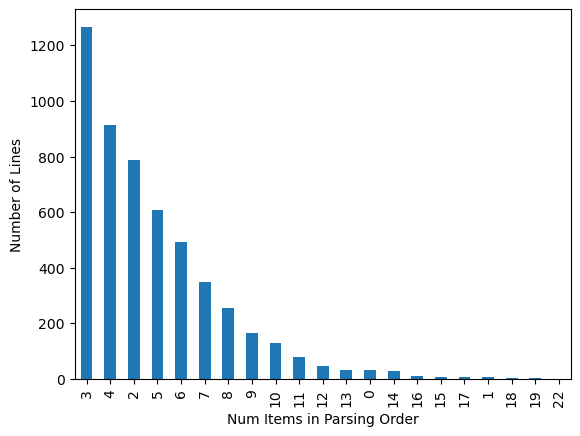

In [50]:
df_errors.parsing_order_len.value_counts().transpose().plot.bar()
plt.xlabel("Num Items in Parsing Order")
plt.ylabel("Number of Lines")
plt.show()

In [59]:
# Explore the rows with empty parsing order
# TODO: explore why 32 rows have empty parsing orders
print(f'{df_errors[df_errors.parsing_order_len == 0].shape}')
with pd.option_context('display.max_colwidth', None):
    display(df_errors[df_errors.parsing_order_len == 0])

(32, 23)


,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len
440,440,18,29,daeec1fa32f04db8a029f6cfe42d541e117b4e7621f61ae9fddbc7b5016766fc,SPA 3,Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800’s o más patras.También van en la futuro.,Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800’s o más patras.También van en [la]{el}<ga:mf:det:inan> futuro.,1,[la]{el}<ga:mf:det:inan>,0,...,"[Bill, and, Ted, es, de, los, dos, Bill, and, Ted, y, els, van, en, diferentes, tiempos, como, los, 1800, ’, s, o, más, patras, ., También, van, en, el, futuro, .]","[28, 60]",ga,"[Bill, and, Ted, es, de, los, dos, Bill, and, Ted, y, els, van, en, diferentes, tiempos, como, los, 1800, ’, s, o, más, patras, ., También, van, en, la, futuro, .]",gender agreement,[],{},A,ga:mf,0
475,475,37,61,77581a46b29c5a9e1e74abbffea7e7a3c03b59fc3457647f571a1ba1ddbacce3,SPA 3,"Todavía me gusta escuchar ""Destiny's Child"" y su música es estupendo.","Todavía me gusta escuchar ""Destiny's Child"" y su música es [estupendo]{estupenda}<ga:fm:adj:inan>.",1,[estupendo]{estupenda}<ga:fm:adj:inan>,0,...,"[Todavía, me, gusta, escuchar, "", Destiny, ', s, Child, "", y, su, música, es, estupenda, .]","[14, 31]",ga,"[Todavía, me, gusta, escuchar, "", Destiny, ', s, Child, "", y, su, música, es, estupendo, .]",gender agreement,[],{},A,ga:fm,0
480,480,40,65,139d6a79730caee9d68ad994e3fb047e5c0b6b31d42450bcf838d3943b5e33dc,SPA 3,Empezó con el grupo se llama Destiny's Child antes de realizar solo.,Empezó con el grupo se llama Destiny's Child antes de realizar [solo]{sola}<ga:fm:adj:an>.,1,[solo]{sola}<ga:fm:adj:an>,0,...,"[Empezó, con, el, grupo, se, llama, Destiny, ', s, Child, antes, de, realizar, sola, .]","[13, 29]",ga,"[Empezó, con, el, grupo, se, llama, Destiny, ', s, Child, antes, de, realizar, solo, .]",gender agreement,[],{},A,ga:fm,0
557,557,71,116,28526173ab7475ff6725e2452e514b8db20dbb75ee46547706df4caf7bfe7db4,SPA 2,"Ella tiene el pelo largo y negro, grande ojos de negro y una voz profunda.","Ella tiene el pelo largo y negro, [grande]{grandes}<na:ps:adj:inan> ojos de negro y una voz profunda.",1,[grande]{grandes}<na:ps:adj:inan>,0,...,"[Ella, tiene, el, pelo, largo, y, negro, ,, grandes, ojos, de, negro, y, una, voz, profunda, .]","[8, 26]",na,"[Ella, tiene, el, pelo, largo, y, negro, ,, grande, ojos, de, negro, y, una, voz, profunda, .]",number agreement,[],{},A,na:ps,0
874,874,201,298,d539be0f37ba2351c41b5ce478dfc7a23b8bb61a7256f29cb0bef8e2e203e25f,SPA 2,Hugh Jackman es un buen actor pero también es un buen cantante y bailarina.,Hugh Jackman es un buen actor pero también es un buen cantante y [bailarina]{bailarín}<ga:mf:noun:an>.,1,[bailarina]{bailarín}<ga:mf:noun:an>,0,...,"[Hugh, Jackman, es, un, buen, actor, pero, tambie, ́, n, es, un, buen, cantante, y, bailarín, .]","[15, 33]",ga,"[Hugh, Jackman, es, un, buen, actor, pero, tambie, ́, n, es, un, buen, cantante, y, bailarina, .]",gender agreement,[],{},A,ga:mf,0
946,946,229,336,52d24c89b5a3209f034532a43e7693abc52d49d3f25a2ae4aeaf0e32de8a6a45,SPA 2,"Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.","Me gustan muchos tipos de musica (rap, r&b,pop) , y [muchas]{muchos}<ga:mf:det:an> artistas.",1,[muchas]{muchos}<ga:mf:det:an>,0,...,"[Me, gustan, muchos, tipos, de, musica, (, rap, ,, r, &, b, ,, pop, ), ,, y, muchos, artistas, .]","[17, 38]",ga,"[Me, gustan, muchos, tipos, de, musica, (, rap, ,, r, &, b, ,, pop, ), ,, y, muchas, artistas, .]",gender agreement,[],{},A,ga:mf,0
1117,1117,282,412,6004f54d6469a368868a7377b03f3e9eb8d7a780202ab1862ad151095ab6e16b,SPA 3,"Después Harry Potter, J. K. Rowling ha estado muy ocupado.","Después Harry Potter, J. K. Rowling ha estado muy [ocupado]{ocupada}<ga:fm:adj:an>.",1,[ocupado]{ocupada}<ga

In [53]:
df_errors[df_errors.essay_new == 'Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.']

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len
946,946,229,336,52d24c89b5a3209f034532a43e7693abc52d49d3f25a2a...,SPA 2,"Me gustan muchos tipos de musica (rap, r&b,pop...","Me gustan muchos tipos de musica (rap, r&b,pop...",1,[muchas]{muchos}<ga:mf:det:an>,0,...,"[Me, gustan, muchos, tipos, de, musica, (, rap...","[17, 38]",ga,"[Me, gustan, muchos, tipos, de, musica, (, rap...",gender agreement,[],{},A,ga:mf,0


In [62]:
ids_to_check = [946, 4833]
# print(df_errors.iloc[id_to_check])
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].essay_new))
for idx in ids_to_check:
    COWSL2H_parsing_order(NLP_ES, df_errors, idx)
# parsing_order = dep_parsing_tree(NLP_ES, df_errors.iloc[id_to_check].essay_new, eval(df_errors.iloc[id_to_check].correction_index), verbosity=2)


id -> head: {0: 1, 1: 1, 2: 3, 3: 1, 4: 5, 5: 3, 7: 3, 9: 7, 11: 7, 14: 16, 15: 16, 16: 1}
head -> ids: {1: [0, 1, 3, 16], 3: [2, 5, 7], 5: [4], 7: [9, 11], 16: [14, 15]}
idx:17, as_list: [], as_map: {}
idx:38, as_list: [], as_map: {}


-----------------------------------------------

Orig: Me gustan muchos tipos de musica ( rap , r & b , pop ) , y muchas artistas .
Corr: Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.
row.source: ['Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchas', 'artistas', '.']
row.target: ['Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchos', 'artistas', '.']
Concatenated: ['Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchas', 'artistas', '.', 'SEP', 'Me', 'gustan', 'muchos', 'tipos', 'de', 'musica', '(', 'rap', ',', 'r', '&', 'b', ',', 'pop', ')', ',', 'y', 'muchos', 'artistas', '.']

Correction index: [17, 38]

Corrected offset: 21

computed pred_parse_order: {}
id -> head: {0: 2, 1: 2, 2: 4, 4: 4, 5: 6, 6: 4, 7: 10, 8: 10, 9: 10, 10: 4, 11: 10, 12: 11}
head -> ids: {2: [0, 1]

-----------------------------------------------

Orig: Para este vacaciones , quiero my novio y mis mejores amigas ir conmigo .
Corr: Para este vacacion, quiero my novio y mi mejor amigas ir conmigo.
row.source: ['Para', 'este', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.']
row.target: ['Para', 'esta', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.']
Concatenated: ['Para', 'este', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.', 'SEP', 'Para', 'esta', 'vacaciones', ',', 'quiero', 'my', 'novio', 'y', 'mis', 'mejores', 'amigas', 'ir', 'conmigo', '.']

Correction index: [1, 16]

Corrected offset: 15

computed pred_parse_order: {'1': 2, '2': 4, '0': 2}


In [63]:
df_errors.sample(2)

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,anno_error_cnt,full_error_tag,order_tag,...,target,correction_index,error_type,source,new_error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,parsing_order_len
2524,2524,873,1483,f32ab9a699014e1127ec302e5b33291c2039d7bb8f3b4a...,SPA 3,En el días jugaremos juegos y iremos al lago y...,En [el]{los}<na:ps:det:inan> días jugaremos ju...,1,[el]{los}<na:ps:det:inan>,0,...,"[En, los, días, jugaremos, juegos, y, iremos, ...","[1, 14]",na,"[En, el, días, jugaremos, juegos, y, iremos, a...",number agreement,[],"{'1': 2, '2': 3, '0': 2}",A,na:ps,3
2719,2719,954,1628,3947a07596b92498c72e58139a082a684a9ff84373b00e...,SPA 3,"No importa que país yo iría, solamente quiero ...","No importa que país yo iría, solamente quiero ...",1,[el]{los}<na:ps:det:inan>,0,...,"[No, importa, que, país, yo, iría, ,, solament...","[20, 45]",na,"[No, importa, que, país, yo, iría, ,, solament...",number agreement,[],"{'20': 21, '21': 18, '19': 21, '22': 21}",A,na:ps,4


## To JSON representation of each row

In [64]:
def to_json_df(in_df):
    df_proj = in_df[['target', 'source', 'evidence_index', 'correction_index', 'error_type', 'predicted_parsing_order', 'origin']]
    df_proj = df_proj.dropna()
    df_json = df_proj.copy(deep=True)
    df_json['json'] = df_proj.apply(lambda x: x.to_json(), axis=1)
    return df_json[['json']]


In [68]:
def export_as_json(df):
    def write_out(df, filename):
        with open(f'{args.PROCESSED_DATA_FOLDER}/{filename}', "w+") as file1:
            for i, row in df.iterrows():
                file1.write(f'{json.dumps(eval(row.json))}\n')

    json_df = to_json_df(df)
    from sklearn.model_selection import train_test_split

    train_df, test_dev_df = train_test_split(json_df, test_size=0.2)
    test_df, dev_df = train_test_split(test_dev_df, test_size=0.5)
    # tt.to_csv(args.PROCESSED_DATA_FOLDER + "/rows_as_json.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar=" ")
    write_out(train_df, args.GEC_TRAIN_CSV)
    write_out(test_df, args.GEC_TEST_CSV)
    write_out(dev_df, args.GEC_DEV_CSV')

# Export after remove lines with empty predicted parsing order until the underlying data is fixed.
export_as_json(df_errors[df_errors.parsing_order_len > 0])

## Convert to NER Format

In [78]:
# Helper methods to convert to NER format
def idx2vec(idx, length):
    if isinstance(idx, list):
        if len(idx) != 0:
            idx_vec = [1 if i in idx else 0 for i in range(length)]
        else:
            idx_vec = [0] * length
    elif isinstance(idx, dict):
        idx_vec = [0] * length
        for k, v in idx.items():
            if int(k) < len(idx_vec):
                idx_vec[int(k)] = v
    return idx_vec

def to_ner(csv_filename, pkl_filename):
    sep_token = ['[MOD]']
    data = []
    
    with open(f'{args.PROCESSED_DATA_FOLDER}/{csv_filename}', 'r') as f:
        for line in f:
            data.append(json.loads(line))
    
    
    # convert into ner data structure
    def sent_to_ner_data(sentence, evidence_index, correction_index, error_type, parsing_order, ids=0, prefix=True):
        sent_data = []
        for j, token in enumerate(sentence):
            new_tokens = token
            if evidence_index:  # for dev and train data
                if evidence_index[j]:
                    type = classes_ids[error_type]
                    if prefix:
                        if j == 0 or evidence_index[j - 1] == 0:
                            cls = 'B-' + type
                        else:
                            cls = 'I-' + type
                    else:
                        cls = type
                else:
                    cls = 'O'
                sent_data.append([
                    ids,
                    new_tokens,
                    cls,
                    classes_ids[error_type],
                    correction_index[j],
                    parsing_order[j]
                ])
        return sent_data

    new_data = []
    for i, d in tqdm(enumerate(data)):
        sentence = d['target'] + sep_token + d['source']
        correction_index = idx2vec(d['correction_index'], len(sentence))
        evidence_index = idx2vec(d['evidence_index'], len(sentence))
        predicted_parsing_order = idx2vec(d['predicted_parsing_order'], len(sentence))
        ner_d = sent_to_ner_data(sentence, evidence_index, correction_index, d['error_type'], predicted_parsing_order, ids=i)
        new_data.extend(ner_d)

    with open(f'{args.PROCESSED_DATA_FOLDER}/{pkl_filename}', 'wb') as f:
        pickle.dump(new_data, f)
    

    

In [79]:
# Convert training dataset to NER
to_ner(args.GEC_TRAIN_CSV, args.GEC_TRAIN_NER)

# Convert test dataset to NER
to_ner(args.GEC_TEST_CSV, args.GEC_TEST_NER)

# Convert dev dataset to NER
to_ner(args.GEC_DEV_CSV, args.GEC_DEV_NER)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]